# Tutorial 2: Bayesian Optimization

In this tutorial notebook we'll implement all the basic components of Bayesian optimization (BO), and see how to use BO for some sample functions.

## 0. Glossary and General Introduction

### 0.1 Bayes' Theorem

First, let's start with the absolute basics of Bayesian inference, the Bayes' theorem
    $$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

- $P(A|B)$ is the _posterior probablity_ of event $A$ given that event B is observed.
- $P(B|A)$ is the _likelihood function_ of A given B; it is also the conditional probablity of observing $B$ given $A$.
- $P(A), P(B)$ are the _prior probabilities_ of observing $A$ and $B$, also known as _marginal probability_

For most applications, the observed event $B$ is already fixed and we can consider $P(B)$ simply as a constant. Thus the Bayes' theorem reads
    $$P(A|B) \propto P(B|A) P(A) $$,
i.e. the __posterior probability__ is proportional to __priors__ times __likelihood__.

### 0.2 Gaussian Process

A Gaussian process (GP) is a stochastic process (a joint distribution of infinitely many random variables), which can be used as a probablistic model (surrogate model) for the objective function in regression and classification tasks.

A GP can be fully described by it's mean $\mu$ and covariance function $k(\cdot,\cdot)$
    $$f(x) \sim \mathcal{GP}(\mu(x), k(x,x'))$$,
where $x$ and $x'$ are points in the input space. 

- __Gaussian process regression (GPR)__, also formerly known as _kriging_: a method to interpolate a unkown objective function.
- __Prior mean__ $\mu(x)$: basic building block of GP; prior belief on the averaged objective function values, usually set to a constant if the function behaivor is unknown.
- __Kernel__ $k(\cdot,\cdot)$, also known as the _covariance function_ $cov(\cdot,\cdot)$: basic building block of GP; prior belief on the characteristics of the unkown function.

#### 0.2.1 Common Kernels used in GP

Some of the commonly used kernels are listed below. They can also be combined to build more complex kernels representing the underlying physics of the objective function.

For simplicity reason, we define $d_{x,x'}$ as the Euclidean distance between the two points
    $$ d_{x,x'} := ||x - x'||_2 $$

- Linear: $k_\mathrm{L}(x,x') = x^\intercal x'$. A special case that one might not often use (non-stationary kernel), this reduces GP essentially back to Bayesian linear regression.
- __White Gaussian noise__: $k_\mathrm{n}(x,x')=\sigma_{n}^2 \delta_{x,x'}$ , i.e. a diagnal noise term with Gaussian noise $\sigma_{n}^2$.
- __Radial basis function (RBF)__, also known as squared exponential (SE): $k_{\mathrm{RBF}} (x,x') = \exp(-\frac{d_{x,x'}^2}{2 l^2})$ , where $l$ is the lengthscale, see below. This resembles a normal Gaussian distribution. It is more or less _the default_ choice of kernel for GPs if one does not have a special assumption on the objective function.
- Rational quadratic (RQ): $k_\mathrm{RQ}=\left( 1 + \frac{d_{x,x'}}{2\alpha l^2} \right)^{-\alpha}$, equivalent of sum of RBF kernels with many different lengthscales. Approaches RBF when $\alpha \to \infty$
- Matérn: $k_\mathrm{Matern} (x,x') = \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \sqrt{2\nu d_{x,x'}} / l \right)^\nu K_\nu \left( \sqrt{2\nu d_{x,x'}} / l \right) $, where $\Gamma$ is the gamma function, $K_\nu$ the modified Bessel function and $\nu$ the parameter of the Matérn kernel. Common choices are $\nu=\frac{3}{2},\frac{5}{2},...$ for once and twice differentiable functions.
- Ornstein-Uhlenbeck: $k_\mathrm{OU}(x,x')=\exp(-d_{x,x'}/l)$


#### 0.2.2 GP Hyperparamters 

The characteristics of GP, or its ability to approximate the unknown function are dependent both on __the choice of the covariance function__ and the __values of the hyperparamters__. The hyperparamters are usually either choosen manually based on the physics, or obtained from the maximum likelihood fit (log-likelihood fit, maximum a posteriori fit) during the optimization.

- __Lengthscale__ $l$: controls the scaling of different input dimensions, i.e. how fast the objective function is expected to change from observed points.
- __Noise variance__  $\sigma_\mathrm{n}^2$: magnitude of the noise in the observed values.
- __Signal variance__ $\sigma^2$: a scaling factor to be multiplied to the kernel function, it is essentially equivalent to normalize/scale the objective function.


### 0.3 Bayesian Optimization

Bayesian optimization is a sequential algorithm to globally optimize an unknown function.

Below are some common terms used in the BO field, some of which are often used interchangeably.

- __Acquisition function__ $\alpha$: is built on the GP posterior, controls the behavior of optimization. For the standard verison of BO, the next sample point is chosen at $\mathrm{argmax}(x)$. In this tutorial we will introduce two widely used acquisition functions: the expected improvment (EI) and the upper confidence bound (UCB).
- __Objective__, metric, or target function: a unknown (black-box) function, for which the value is to be optimized (here: maximization).
- __Search space__, bounds, or optimization range: A (continous) parameter space where the input parameters are allowed to be varied in the optimization.


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, RationalQuadratic
from sklearn.datasets import make_friedman2
from skopt import gp_minimize
from scipy.optimize import minimize
from utils.gp_helper import plot_gpr_samples, plot_gp, plot_gp_with_acq, plot_bo_result, AcqUCB, AcqEI

# Suppress some warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Build a Gaussian Process

Here we will use the [scikit-learn](https://scikit-learn.org/stable/modules/gaussian_process.html) to build a Gaussian process model.
In the end of this notebook you will also find a incomplete set of other commonly used GP and BO libraries.


**Stephan**: Maybe add a Lego (predfeined building blocks) reference? 
             GP and BO "programming libraries" maybe?
             

In [2]:
# Define a RBF kernel (covariance function)
k_rbf = 1 * RBF(length_scale=1.0, length_scale_bounds='fixed')  # with a 'fixed' length_scale
# Initialize a GP model
gp_with_rbf = GaussianProcessRegressor(kernel=k_rbf)


Now we can sample some functions from the prior distribution (which is essentially a constant function with some standard deviation).


_Remark_: The actual function calls for GP prediction in `plot_gpr_samples`

```python
# Predict GP mean and std
y_mean, y_std = gpr_model.predict(x, return_std=True)
# Sample functions from the GP distribution
y_samples = gpr_model.sample_y(x, n_samples)
```

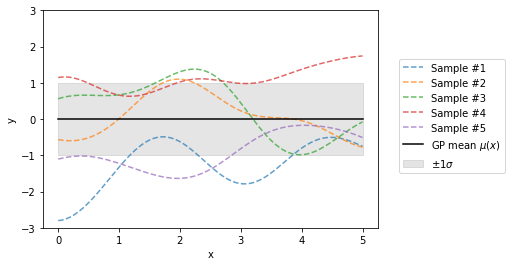

In [3]:
x = np.linspace(0,5,200)
fig, ax = plt.subplots()
plot_gpr_samples(gp_with_rbf, ax=ax, x=x, n_samples=5, random_state=0)
ax.set_ylim(-3,3)
ax.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

Let's also define some GPs with other kernels for comparison 

In [4]:
# [Feel free to also modify the length scale parameter to see the effects]
k_rq = 1 * RationalQuadratic(length_scale=1.0, length_scale_bounds='fixed', alpha=1)
k_matern32 = Matern(length_scale=1.0, length_scale_bounds='fixed', nu=3/2)
k_matern52 = Matern(length_scale=1.0, length_scale_bounds='fixed', nu=5/2)

gp_with_rq = GaussianProcessRegressor(kernel=k_rq)
gp_with_matern32 = GaussianProcessRegressor(kernel=k_matern32)
gp_with_matern52 = GaussianProcessRegressor(kernel=k_matern52)

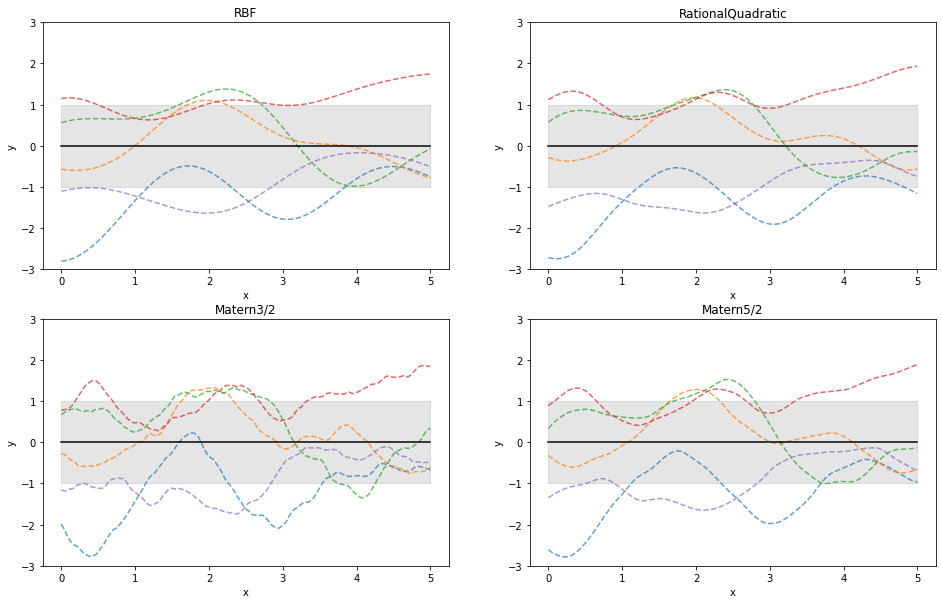

In [5]:
x = np.linspace(0,5,200)
fig, axes = plt.subplots(2,2,figsize=(16,10))
plt_titles = ["RBF","RationalQuadratic","Matern3/2","Matern5/2"]
plot_gpr_samples(gp_with_rbf, ax=axes[0,0], x=x, n_samples=5)
plot_gpr_samples(gp_with_rq, ax=axes[0,1], x=x, n_samples=5)
plot_gpr_samples(gp_with_matern32, ax=axes[1,0], x=x, n_samples=5)
plot_gpr_samples(gp_with_matern52, ax=axes[1,1], x=x, n_samples=5)
for i, ax in enumerate(axes.flatten()):
    ax.set_ylim(-3,3)
    ax.set_title(plt_titles[i])


Here we clearly see that the sampled functions from RBF and RQ kernels are more smooth than the Matern ones.

## 2. Define an Unkown Target Function

We'll define a target function with multiple local optima as the objective function for optimization.

In [6]:
def f_target(x, noise=0.1, rng = np.random.default_rng()):
    f = (-1.4 + 3.0 * x) * np.sin(18.0 * x)
    return f + rng.random(x.shape) * noise


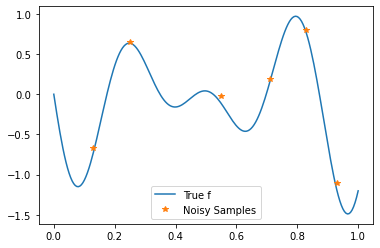

In [7]:
# Let's visualize it
xlow, xhigh = 0, 1
x = np.linspace(xlow,xhigh,200)
y = f_target(x, noise=0)
x_samples = np.array([0.13, 0.93, 0.25, 0.55, 0.71, 0.83])   # for now, just manually define some observations for reproducibility :)

# Other wide one can define a seeded random generator for reproducibility
rng = np.random.default_rng(1)
# x_samples = rng.uniform(low=xlow,high=xhigh,size=6)
y_samples = f_target(x_samples, noise=0.1, rng=rng)

plt.plot(x,y,label='True f')
plt.plot(x_samples,y_samples,"*",label="Noisy Samples")
plt.legend()

Now let's see how the GP posterior distribution looks like with some observed points.

Figure legends:
- black: GP posterior mean function
- gray shadow: $\pm 1$ std. from GP posterior

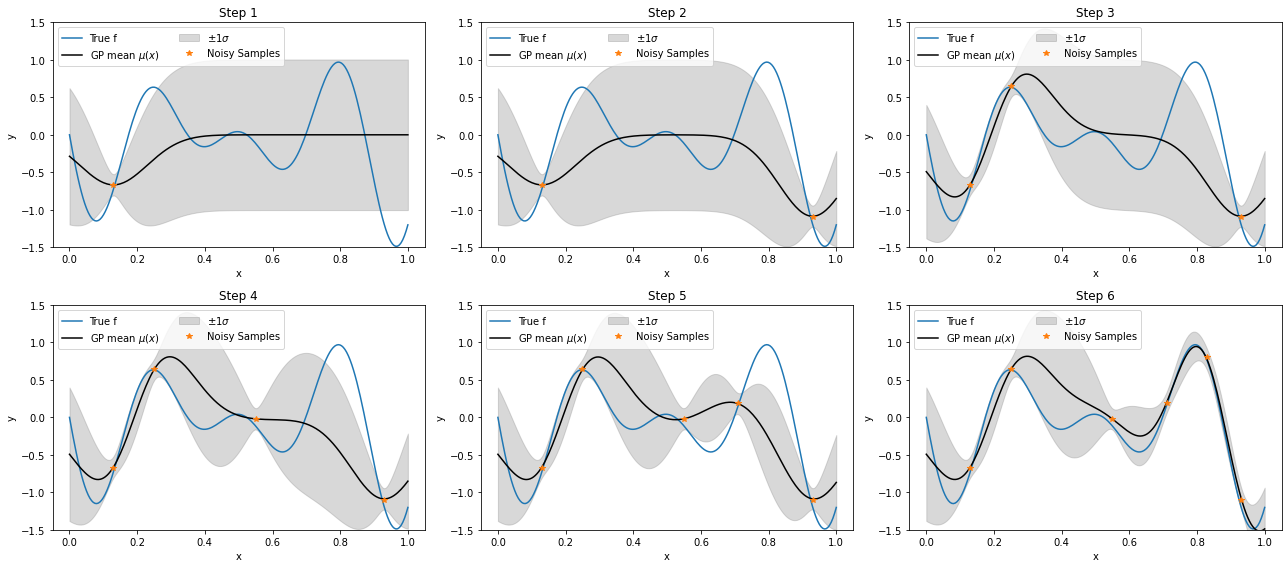

In [8]:
# let's see how GP is fitted to the observations
kernel = RBF(length_scale=0.1, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1**2, noise_level_bounds='fixed')
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

nstep=1
# fit GP to the function and plot posterior
fig,axes = plt.subplots(2,3,figsize=(18,8))
for nstep in range(6):
    ax = axes.flatten()[nstep]
    gpr.fit(x_samples.reshape(-1,1)[:nstep+1],y_samples[:nstep+1])
    ax.set_title(f"Step {nstep+1}")
    plot_gp(gpr, x, y, x_samples[:nstep+1], y_samples[:nstep+1], ax=ax)
    ax.set_ylim(-1.5,1.5)
    ax.legend(ncol=2)
plt.tight_layout()  # Stephan: keeps title and xlabel apart


Feel free to change the length_scale below to see the difference in resulted GP posteriors.

For example, one can vary from small to large lengthscales like `[0.01, 0.1, 0.5]`, or enable automatic lengthscale fitting within a specified range via setting `length_scale_bounds=[1e-3,1e2]`.

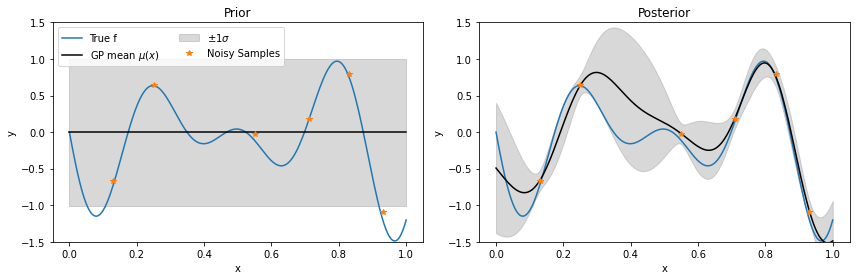

In [9]:
# let's redefine GP model with 

kernel = RBF(length_scale=0.1, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1**2, noise_level_bounds='fixed')
#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Visualize the GP fitted to the target function
fig, axes = plt.subplots(1,2, figsize=(12,4))
ax1, ax2 = axes

# plot GP prior
ax1.set_title("Prior")
plot_gp(gpr, x, y, x_samples, y_samples, ax=ax1)

# fit GP to the function and plot posterior
gpr.fit(x_samples.reshape(-1,1),y_samples)
ax2.set_title("Posterior")
plot_gp(gpr, x, y, x_samples, y_samples, ax=ax2)
ax1.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)

fig.tight_layout()
ax1.legend(ncol=2)


## 3. Maximization of the acquisition function

With the GP model approximating the objective function, we can build an acquisition function to assess what will be the most valuable point to sample at next step.

Here we will implement two acquisition functions: 

The __expected improvement (EI)__
$$ \begin{split}   
\alpha_{\text{EI}} (x)  &= \mathbb{E} [ \max (\mu (x)-(f_{\text{best}}+\xi),0)  ] \\  
&= (\mu(x)-(f_{\text{best}}+\xi)) \Phi (Z) + \sigma (x)\phi (Z) 
\end{split}, 
$$
where
$$
\begin{split}
         Z  & = \frac{\mu(x)-(f_{\text{best}}+\xi)}{\sigma(x)}.
\end{split}
$$

The EI acquisition calculates the expectation value of improvement of the function value at a to-be-sampled point $x$ compared to the best observation so far $f_{\text{best}}$.

Another is the __upper confidence bound (UCB)__
$$
    \alpha_{\text{UCB}} (x) = \mu(x) + \kappa \sigma (x),
$$
which calculates the posterior mean $\mu$ plus a factor times the standard deviation $\sigma$ at a to-be-sampled point $x$.

See `utils/gp_helper.py` for the implementation of the acquisition fucntions.

Other popular acquisition functions are: entropy search, knoledge gradient, etc...

__Exploration-exploitation tradeoff__: the behaviour of the acquisition fucntions are controlled via the hyperparameters $\xi$ and $\kappa$. Larger values lead to more exploration and vice versa.

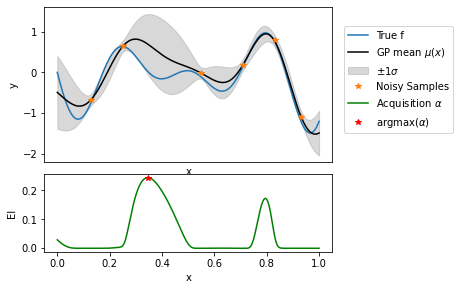

In [10]:
# Define a EI acquisition
acq_EI = AcqEI(xi=0.)  # feel free to change the value of xi to see the different behaviour of EI

# Calculate the acquisition function
y_acq = acq_EI.get_acq(x.reshape(-1,1), gpr)

# Visualize the acquisition functions 

fig, axes = plt.subplots(2,1,figsize=(5,4),gridspec_kw={"height_ratios": [2,1]})
ax1, ax2 = axes
ax2.set_ylabel('EI')

plot_gp_with_acq(gpr, x, y, x_samples, y_samples, y_acq, axes=axes, fig=fig)

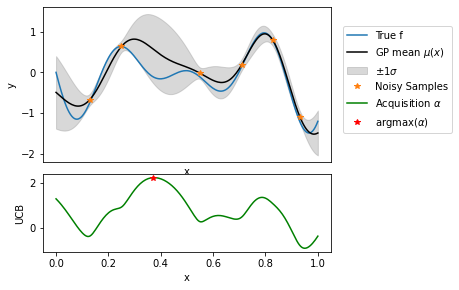

In [11]:
# Define a UCB acquisition
acq_UCB = AcqUCB(k=2)  # feel free to change the value of xi to see the different behaviour of EI

# Calculate the acquisition function
y_acq = acq_UCB.get_acq(x.reshape(-1,1), gpr)

# Visualize the acquisition functions 

fig, axes = plt.subplots(2,1,figsize=(5,4),gridspec_kw={"height_ratios": [2,1]})
ax1, ax2 = axes
ax2.set_ylabel('UCB')

plot_gp_with_acq(gpr, x, y, x_samples, y_samples, y_acq, axes=axes, fig=fig)


## 4. Maximize the Target Function

_Note_: Here the code is used to maximize a unknown target fucntion. For minimization tasks, one can simply multiply -1 to the target function.

Some helper functions are imported to plot the progress of BO, see `utils/gp_helper.py`

The most simple form of Bayesian optimization can be divided in following steps:

1. Initialize GP model $\mathcal{GP}(\mu, \sigma)$
2. Build acquisition function $\alpha$
3. Sample next point $x_i$ of target function $f$ at $\text{argmax}(\alpha)$
4. Observe $y_i = f(x_{i})$ and refit GP model.



First, let's see some BO steps in action


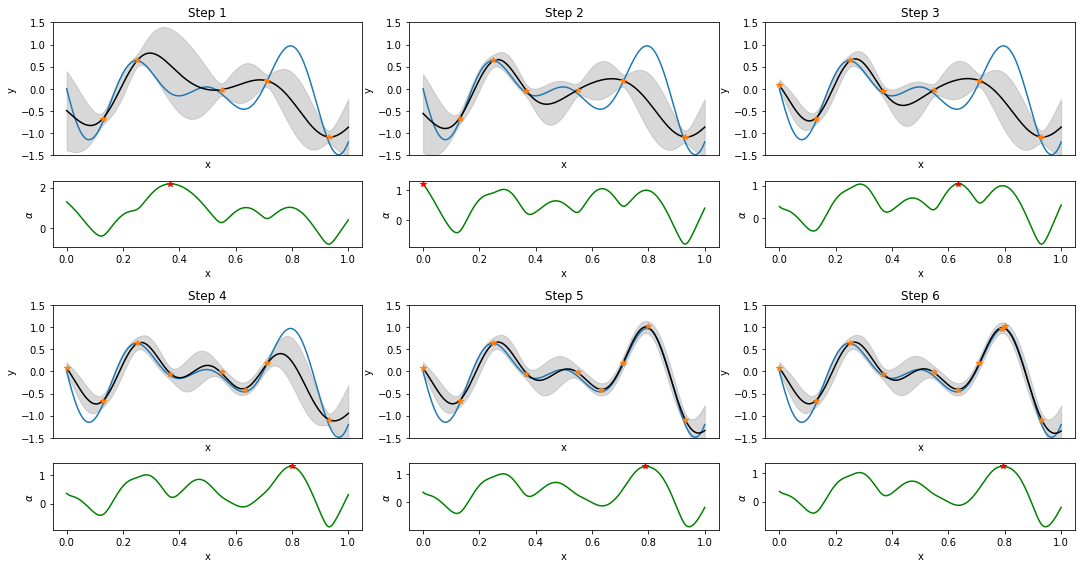

In [19]:
# redefine the sample points for reproducibility
rng = np.random.default_rng(1)
X = np.array([0.13, 0.93, 0.25, 0.55, 0.71,])
Y = f_target(X, noise=0.1, rng=rng)
# define a GP with RBF kernel
kernel = RBF(length_scale=0.1, length_scale_bounds="fixed") + WhiteKernel(noise_level=0.1**2, noise_level_bounds='fixed')
gpr = GaussianProcessRegressor(kernel=kernel)
# define an acquisition function 
myacq = AcqUCB(k=2)

fig = plt.figure(figsize=(15,8))
gs = GridSpec(2, 3, figure=fig)

for i in range(6):
    # Fit GP model to observed data
    gpr.fit(X.reshape(-1,1), Y.reshape(-1,1))
    # Calculate the acquisition function
    y_acq = myacq.get_acq(x.reshape(-1,1), gpr)

    # Visualize the acquisition functions 
    inner_grid = gs[np.unravel_index(i, [2,3])].subgridspec(2, 1, height_ratios=[2,1])
    axes = inner_grid.subplots()
    axes[0].set_title(f"Step {i+1}")
    axes[0].set_ylim(-1.5,1.5)
    axes[1].set_ylabel(r"$\alpha$")
    plot_gp_with_acq(gpr, x, y, X, Y, y_acq, axes=axes, fig=fig, legend=False)
    # Append new data
    x_next = x[np.argmax(y_acq)]
    y_next = f_target(x_next, noise=0.1, rng=rng)
    X = np.vstack([X.reshape(-1,1), x_next.reshape(-1,1)])
    Y = np.vstack([Y.reshape(-1,1), y_next.reshape(-1,1)])
fig.tight_layout()

Now we bring the components together and define a optimizer function 

In [20]:
# Define a simple Bayesian optimizer  

def bayesian_optimize(
    gpmodel: GaussianProcessRegressor, 
    acquisition, 
    target_func, 
    init_points=None, 
    steps=50, 
    bounds=None, 
    xdim=1, 
    rng=np.random.default_rng()):
    
    # for logging purpose
    history = {
        "X_init": [],
        "Y_init": [],
        "X": [],
        "Y": [],
        "X_best": [],
        "Y_best": [],
        }

    # Initial samples to start with 
    if init_points is None:
        init_points = rng.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(3, xdim))
    y_init = []
    for xi in init_points:
        y_init.append(target_func(xi))
    y_init = np.array(y_init)
    history["X_init"] = init_points
    history["Y_init"] = y_init
    n_init = init_points.shape[0]

    X = init_points.reshape(-1,xdim)
    Y = y_init.reshape(-1,1)
    
    # Actual optimization step
    for _ in range(steps):
        # fit gp model
        gpmodel.fit(X, Y)
        # maximize acquisition
        x_next = acquisition.suggest_next_sample(gpmodel, bounds=bounds)
        # sample at argmax(acquisition)
        y_next = target_func(x_next)
        # augment data
        X = np.vstack([X, x_next.reshape(-1,xdim)])
        Y = np.vstack([Y, y_next.reshape(-1,1)])
    
    # log process
    history["X"] = X[n_init:]
    history["Y"] = Y[n_init:]
    i_best = Y.argmax()
    history["X_best"] = X[i_best]
    history["Y_best"] = Y[i_best]
    
    return gpmodel, history


In [21]:
%%capture
# Start Optimization [Feel free to play around with the parameters in this block and observe effects]

# define a GP model
kernel = 1 * RBF(length_scale=0.5, length_scale_bounds=[1e-2,1]) + WhiteKernel(noise_level=0.1) # allow automatic determination of length-scale
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
# define a Acquisition function
myacq = AcqEI(xi=0.001)

# start BO
bounds = np.array([[0,1]])
nsteps=30
gpr, history = bayesian_optimize(gpr, myacq, target_func=f_target, steps=nsteps, bounds=bounds, rng=rng)

Text(0, 0.5, 'y')

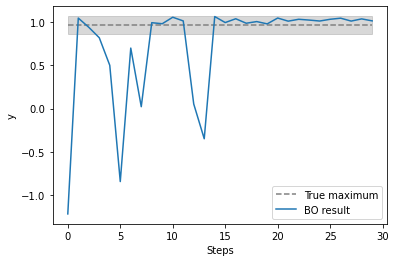

In [22]:
# Visualize Results
fig, ax = plt.subplots()
x_fine = np.linspace(0,1,500)
y_fine = f_target(x_fine,noise=0)
ymax = np.ones(nsteps)*y_fine.max()
ax.plot(ymax, ls='--',color='gray', label='True maximum')
ax.fill_between(np.arange(nsteps), ymax-0.1, ymax+0.1, alpha=0.3, color='gray')
ax.plot(history["Y"], label="BO result")
ax.legend()
ax.set_xlabel("Steps")
ax.set_ylabel("y")

## Performance benchmark (Optional Module)

against "classical" algorithms:
- Nelder-Mead
- Newtonian methods

### Define a more complex function

Let's use the Ackley function:
$$
    f(x_1,x_2) = -20 \exp \left[-0.2 \sqrt{0.5(x_1^2+x_2^2)} \right] - \exp \left[0.5(\cos(2\pi x_1) + \cos(2\pi x_2)) \right] + e + 20
$$

![](img/ackley.png)


In [23]:
# Define more complex functions
def f_ackley(x: np.ndarray, yhist = None) -> np.ndarray:
    """func_log: used to track the optimization progress"""
    assert x.shape[1] ==2
    y = -20 * np.exp(-0.2 * np.sqrt(0.5 * np.sum(np.square(x), axis=1))) 
    y -= np.exp(0.5*(np.cos(2*np.pi*x[:,0]) + np.cos(2*np.pi*x[:,1])))
    y += np.e + 20
    y *= -1
    if yhist is not None:
        yhist.append(y)
    return y

### Start optimization with different algorithms

In [43]:
bounds_ackley = np.array([[-5,5],[-5,5]])
n_restart = 5  # try 5 times for each algorithm
maxiter = 100

In [44]:
# Nelder Mead
nm_hist = [0] * n_restart
for i in range(n_restart):
    rng = np.random.default_rng(i)
    x0 = rng.uniform(low=bounds_ackley[:,0], high=bounds_ackley[:,1])
    nm_hist[i] = []
    res = minimize(
        lambda x: -1 * float(f_ackley(np.array(x).reshape(-1,2), nm_hist[i])),
        x0 = x0,
        bounds=bounds_ackley,
        options={'maxfev': maxiter, 'xatol': 1e-10},
        method='Nelder-Mead'
        )

In [46]:
%%capture
# BO our version: more exploitation
bo_hist_exploit = [0] * n_restart
kernel = 1 * RBF(length_scale=0.1, length_scale_bounds=[1e-2,1]) #
for i in range(n_restart):
    rng = np.random.default_rng(i)
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    myacq = AcqEI(xi=0.01)
    bo_hist_exploit[i] = []
    _, _ = bayesian_optimize(
        gpr, myacq, target_func=lambda x: f_ackley(np.array(x).reshape(-1,2), bo_hist_exploit[i]), steps=maxiter, bounds=bounds_ackley, rng=rng, xdim=2
        )

In [48]:
# BO our version: more exploration
bo_hist_explore = [0] * n_restart
kernel = 1 * RBF(length_scale=0.1, length_scale_bounds=[1e-2,1]) #
for i in range(n_restart):
    rng = np.random.default_rng(i)
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    myacq = AcqEI(xi=0.1)
    bo_hist_explore[i] = []
    _, _ = bayesian_optimize(
        gpr, myacq, target_func=lambda x: f_ackley(np.array(x).reshape(-1,2), bo_hist_explore[i]), steps=maxiter, bounds=bounds_ackley, rng=rng, xdim=2
        )

In [49]:
%%capture  
# suppress output

# Default sklearn version of BO
skopt_hist = [0] * n_restart
for i in range(n_restart):
    skopt_hist[i] = []
    res = gp_minimize(lambda x: -1 * float(f_ackley(np.array(x).reshape(-1,2), skopt_hist[i])),dimensions=bounds_ackley,n_calls=maxiter, random_state=i)

In [50]:
# Pure random search, as a baseline
random_hist = np.zeros((n_restart, maxiter))
x_random = np.random.uniform(low=bounds_ackley[:,0], high=bounds_ackley[:,1], size=(n_restart*maxiter,2))
y_random = f_ackley(x=x_random)
random_hist = y_random.reshape((n_restart, maxiter))

### Compare their performance

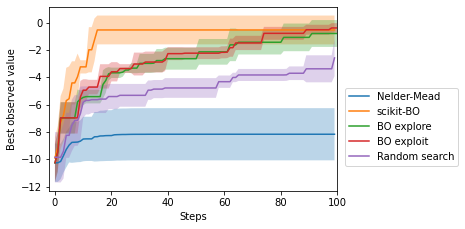

In [68]:
# plot the results
fig,ax = plt.subplots(figsize=(5,3))
plot_bo_result(np.squeeze(nm_hist), ax, label='Nelder-Mead')
plot_bo_result(np.squeeze(skopt_hist), ax, label='scikit-BO')
plot_bo_result(np.squeeze(bo_hist_explore), ax, label='BO explore')
plot_bo_result(np.squeeze(bo_hist_exploit), ax, label='BO exploit')
plot_bo_result(np.squeeze(random_hist), ax, label='Random search')

ax.set_xlim(-2,100)
ax.set_ylabel("Best observed value")
ax.set_xlabel("Steps")


fig.subplots_adjust(0,0,0.8,0.85,hspace=0.1)
fig.legend(bbox_to_anchor = (0.95,0.0,0.2,0.5))
#fig.savefig("img/benchmark_ackley.png",dpi=300,bbox_inches="tight")

Here's the result, incase the optimization is not finished
![](img/benchmark_ackley.png)

---

## What's next?

Hopefully you have learned something about BO, if you want to try it yourself afterwards, below are some interesting resources.


### Publication: Various applications of BO in accelerator physics

- LCLS: [Bayesian optimization of FEL performance at LCLS](https://accelconf.web.cern.ch/ipac2016/doi/JACoW-IPAC2016-WEPOW055.html), [Bayesian Optimization of a Free-Electron Laser](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.124801) FEL performance tuning with quadrupoles
- LUX: [Bayesian Optimization of a Laser-Plasma Accelerator](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.104801) LPA tuning to improve bunch quality with laser energy, focus position, and gas flows.
- Central Laser Facility, Rutherfold UK: [Automation and control of laser wakefield accelerators using Bayesian optimization](https://www.nature.com/articles/s41467-020-20245-6), LWFA performance tuning with different objective functions
- PSI, SwissFEL: [Tuning particle accelerators with safety constraints using Bayesian optimization](https://doi.org/10.1103/PhysRevAccelBeams.25.062802) [Adaptive and Safe Bayesian Optimization in High Dimensions via One-Dimensional Subspaces](https://arxiv.org/abs/1902.03229) : BO with safety contraints to protect the machine
- SLAC, ANL: [Multiobjective Bayesian optimization for online accelerator tuning](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.062801), multiobjective optimization for accelerator tuning,[Turn-key constrained parameter space exploration for particle accelerators using Bayesian active learning](https://www.nature.com/articles/s41467-021-25757-3), Bayesian active learning for effcient exploration of the parameter space. [Differentiable Preisach Modeling for Characterization and Optimization of Particle Accelerator Systems with Hysteresis](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.128.204801) hysteris modelling with GP, and application of hysteresis-aware BO.

### Books and papers on Bayesian optimization in general

- C. E. Rasmussen and C. K.I. Williams, [Gaussian Processes for Machine Learning](https://gaussianprocess.org/gpml/): __the__ classic textbook of Gaussian process.
- Eric Brochu, [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](https://arxiv.org/abs/1012.2599): a comprehensive tutorial on Bayesian optimization with some application cases at that time (2010).
- Peter I. Frazier, [A Tutorial on Bayesian Optimization](https://arxiv.org/abs/1807.02811): a more recent (2018) tutorial paper covering the most important aspects of BO, and some advanced variants of BO (parallel, multi-fidelity, multi-task).


### Bayesian Optimization / Gaussian Process packages in python

Below is a incomplete selection of python packages for BO and GP, each with its own strength and drawback.

- [scikit-learn Gaussian processes](https://scikit-learn.org/stable/modules/gaussian_process.html#) : recommended for sklearn users, not as powerful as other packages.
- [GPyTorch](https://gpytorch.ai/) : a rather new package implemented natively in PyTorch, which makes it very performant. Also comes with a Bayesian optimization package [BOTorch](https://botorch.org/), offering a variety of different optimization methods (mult-objective, parallelization...). Both packages are being actively developed maintained; recommended for PyTorch users.
- [GPflow](https://www.gpflow.org/) : a GP package implemented in TensorFlow, it also has a large community and is being actively maintained; The new BO package [Trieste](https://secondmind-labs.github.io/trieste) is built on it.
- [GPy](http://sheffieldml.github.io/GPy/) from the Sheffield ML group : A common/classic choice for building GP model, includes a lot of advanced GP variants; However in recent years it is not so actively maintained. It comes with the accompanying Bayesian optimization package [GPyOpt](https://github.com/SheffieldML/GPyOpt), for which the maintainance stoped since 2020.
- [Dragonfly] : a open-source BO package; offers also command line tool, easy to use if you are a practitioner. However if one has less freedom to adapt and expand the code.

C.f. the [wikipedia page](https://en.wikipedia.org/wiki/Comparison_of_Gaussian_process_software#Comparison_table) for a more inclusive table with GP packages for other languages.